In [12]:
import json
import os
import pandas as pd
from tqdm import tqdm
from galaxyteam.dataset import resize_image
from matplotlib import image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
# pylint: disable=[E0611,E0401]
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, Lambda,
                                     MaxPooling2D, Input)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow.keras as keras

In [13]:
def _parse(file_name, is_pneumonia):
    '''
    Function that returns a tuple of normalized image array and pneumonia
    classification
    Args:
        file_name (string): Path to image
        is_pneumonia (bool): Boolean indicating whether the x-ray contains
            pneumonia
    returns:
        image_normalized (tf.Tensor): Normalized image tensor
        is_pneumonia (float): 1 or 0 indicating whether the x-ray contains
            pneumonia
    '''
    # Read an image from a file
    image_string = tf.io.read_file(file_name)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # # Resize it to fixed shape
    # image_resized = resize_image(image_decoded, (224, 224, 3))
    return image_decoded, float(is_pneumonia)


def create_dataset(filenames, is_pneumonia, shuffle=False, batch_size=32):
    '''
    Create a tensorflow dataset object and return it.
    Args:
        filenames (iter): List of image paths
        is_pneumonia (iter): List of boolean values indicating if the x-ray
            contains pneumonia
        shuffle (bool): Whether or not to shuffle the dataset after generating
            it (note this is less effective than shuffling the filenames and
            ratings beforehand instead because the whole dataset cannot be
            stored in memory simultaneously.)
        batch_size (int): The number of images per batch
    Returns:
        dataset (tf.data.Dataset): A dataset containing the image and pneumonia
            data
    '''

    # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU
    # idle time
    autotune = tf.data.experimental.AUTOTUNE

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, is_pneumonia))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(_parse, num_parallel_calls=autotune)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)

    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=autotune)

    return dataset


In [14]:
IMG_SIZE = 224
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

In [15]:
def build_TL():
    
    #Input shape = [width, height, color channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [16]:
keras.backend.clear_session()

model_pretrained = build_TL()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [17]:
#Setting callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [18]:
def train_TL(epochs=15, batch_size=32, val_frac=0.2,
              train_info_file_path='./data/preprocessed/train_metadata.csv'):

    full_train = pd.read_csv(train_info_file_path)

    train_data, val_data = train_test_split(full_train, test_size=0.2,
                                            shuffle=True,
                                            stratify=full_train.is_pneumonia,
                                            random_state=9473)

    # Create Tensorflow datasets
    train_dataset = create_dataset(train_data.resized_file_path,
                                   train_data.is_pneumonia,
                                   batch_size=batch_size)
    val_dataset = create_dataset(val_data.resized_file_path,
                                 val_data.is_pneumonia,
                                 batch_size=batch_size)



    history = model_pretrained.fit(train_dataset,callbacks=[early_stopping, plateau], epochs=epochs, verbose=1,
                        validation_data=val_dataset)

    return history, model_pretrained

In [19]:
history, model = train_TL(batch_size=32)

Epoch 1/15
118/118 [==============================] - 594s 5s/step - loss: 37.2017 - binary_accuracy: 0.6190 - val_loss: 16.9931 - val_binary_accuracy: 0.7279 - lr: 5.0000e-05
Epoch 2/15
118/118 [==============================] - 579s 5s/step - loss: 19.7789 - binary_accuracy: 0.6889 - val_loss: 12.9588 - val_binary_accuracy: 0.7524 - lr: 5.0000e-05
Epoch 3/15
118/118 [==============================] - 573s 5s/step - loss: 8.8157 - binary_accuracy: 0.7588 - val_loss: 2.8936 - val_binary_accuracy: 0.8495 - lr: 5.0000e-05
Epoch 4/15
118/118 [==============================] - 606s 5s/step - loss: 3.6598 - binary_accuracy: 0.8154 - val_loss: 1.3074 - val_binary_accuracy: 0.8815 - lr: 5.0000e-05
Epoch 5/15
118/118 [==============================] - 600s 5s/step - loss: 1.5513 - binary_accuracy: 0.8533 - val_loss: 0.5510 - val_binary_accuracy: 0.9082 - lr: 5.0000e-05
Epoch 6/15
118/118 [==============================] - 589s 5s/step - loss: 0.6061 - binary_accuracy: 0.8746 - val_loss: 0.3567

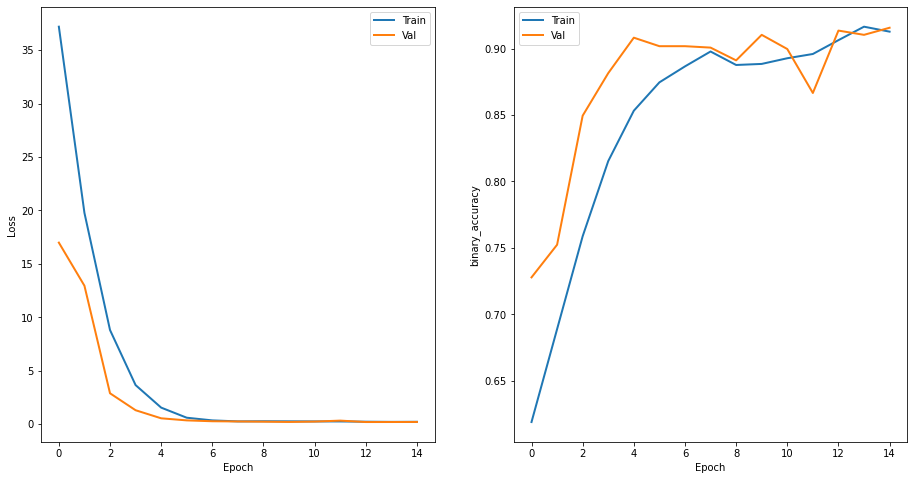

In [23]:
fig = plt.figure(figsize=(24, 8))
sp1 = fig.add_subplot(131)
sp2 = fig.add_subplot(132)

num_epochs = range(0, 15)

sp1.plot(num_epochs, history.history['loss'], linewidth=2, label='Train')
sp1.plot(num_epochs, history.history['val_loss'], linewidth=2, label='Val')

sp2.plot(num_epochs, history.history['binary_accuracy'], linewidth=2, label='Train')
sp2.plot(num_epochs, history.history['val_binary_accuracy'], linewidth=2, label='Val')

sp1.set_xlabel('Epoch')
sp1.set_ylabel('Loss')
sp1.legend()

sp2.set_xlabel('Epoch')
sp2.set_ylabel('binary_accuracy')
sp2.legend()


In [51]:
model.save('TL_v1')

INFO:tensorflow:Assets written to: TL_v1\assets


INFO:tensorflow:Assets written to: TL_v1\assets
